In [3]:
import os
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
from sklearn.metrics import confusion_matrix, classification_report 
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer, TFGPT2Model


os.chdir('C:/Users/makri/OneDrive/Documents/GitHub/Deep_Learning_Final_Project')

data_train = pd.read_csv('multimodal_train.tsv', sep='\t')
data_test = pd.read_csv('multimodal_test_public.tsv', sep='\t')
data_validate = pd.read_csv('multimodal_validate.tsv', sep='\t')

In [2]:
BATCH_SIZE = 32
SEED = 42
# Training data
X_train = data_train['clean_title'].values  
y_train = data_train['2_way_label'].values 

# Validation data
X_val = data_validate['clean_title'].values
y_val = data_validate['2_way_label'].values

train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(buffer_size=len(X_train),seed=SEED, reshuffle_each_iteration=False).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Enable memory growth for the first (and only) GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"Memory growth enabled for {gpus[0]}")
    except RuntimeError as e:
        print(e)  # This happens if GPUs are initialized before setting memory growth
else:
    print("No GPU found. Running on CPU.")

Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
mixed_precision.set_global_policy('mixed_float16')


# Defining Bert Model
bert_model = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
bert_preprocessing_layer = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2'
preprocessor = hub.KerasLayer(bert_preprocessing_layer, name = 'BERT_preprocessor')
encoder = hub.KerasLayer(bert_model, trainable=True, name = 'BERT_encoder')

# Building network
input = tf.keras.layers.Input(shape=(), dtype=tf.string)
processed_text = preprocessor(input)
output = encoder(processed_text)
cls_tokens = output['pooled_output']
# Add dropout
x = tf.keras.layers.Dropout(0.2)(cls_tokens)
# Add linear transformation
x = tf.keras.layers.Dense(1, dtype='float32')(x)
model = tf.keras.models.Model(input,x)

model.summary()





Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 BERT_preprocessor (KerasLayer)  {'input_type_ids':   0          ['input_2[0][0]']                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [10]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
              metrics=['accuracy'])

In [11]:
# Training

history = model.fit(train_ds, epochs=3, validation_data=val_ds)

Epoch 1/3


c:\Users\makri\.conda\envs\tf\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("mul_2:0", dtype=float32), dense_shape=Tensor("Adam/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


17625/17625 [==============================] - 964s 55ms/step - loss: 0.3843 - accuracy: 0.8201 - val_loss: 0.3314 - val_accuracy: 0.8598
Epoch 2/3
17625/17625 [==============================] - 967s 55ms/step - loss: 0.3224 - accuracy: 0.8566 - val_loss: 0.3195 - val_accuracy: 0.8650
Epoch 3/3
17625/17625 [==============================] - 1078s 61ms/step - loss: 0.2960 - accuracy: 0.8711 - val_loss: 0.3207 - val_accuracy: 0.8688


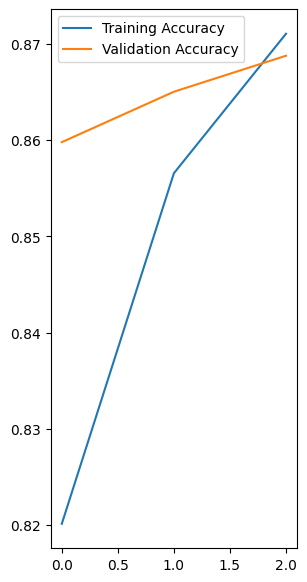

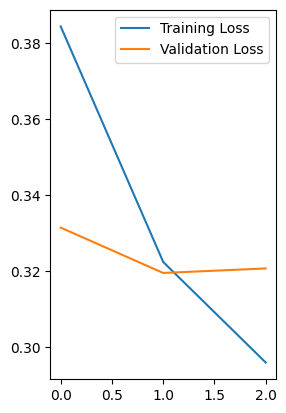

In [12]:
plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()




In [6]:
saved_model_path = './my_model'
#model.save(saved_model_path, include_optimizer=False)

In [14]:
# Test data
X_test = data_test['clean_title'].values
y_test = data_test['2_way_label'].values

loss, accuracy = model.evaluate(X_test, y_test)

1854/1854 [==============================] - 81s 44ms/step - loss: 0.3195 - accuracy: 0.8696


## Reloaded Model ##

In [19]:
reloaded_model = tf.keras.models.load_model(saved_model_path)

reloaded_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
              metrics=['accuracy'])


In [22]:
# Test data
X_test = data_test['clean_title'].values
y_test = data_test['2_way_label'].values

predictions = reloaded_model.predict(X_test)

1854/1854 [==============================] - 78s 42ms/step


In [63]:
threshold = 0.5
preds = (predictions>threshold).astype(int)

print(classification_report(preds,y_test, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       0.91      0.88      0.89     36766
        Real       0.82      0.85      0.83     22553

    accuracy                           0.87     59319
   macro avg       0.86      0.87      0.86     59319
weighted avg       0.87      0.87      0.87     59319



In [76]:
news_examples = [
    "You either have XX or XY chromosomes. Those are the options." 
]




results = tf.sigmoid(reloaded_model(tf.constant(news_examples)))
print(results)

#print(['FAKE'if results>threshold else 'REAL'])

tf.Tensor([[0.05379667]], shape=(1, 1), dtype=float32)


## Larger BERT ##


In [4]:
mixed_precision.set_global_policy('mixed_float16')


# Defining Bert Model
bert_model = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1'
bert_preprocessing_layer = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2'
preprocessor = hub.KerasLayer(bert_preprocessing_layer, name = 'BERT_preprocessor')
encoder = hub.KerasLayer(bert_model, trainable=True, name = 'BERT_encoder')

# Building network
input = tf.keras.layers.Input(shape=(), dtype=tf.string)
processed_text = preprocessor(input)
output = encoder(processed_text)
cls_tokens = output['pooled_output']
# Add dropout
x = tf.keras.layers.Dropout(0.1)(cls_tokens)
# Add Dense Layers 
# x = tf.keras.layers.Dense(1500, activation='relu',dtype='float32')(x)
# x = tf.keras.layers.Dropout(0.1)(cls_tokens)
# x = tf.keras.layers.Dense(100, activation='relu',dtype='float32')(x)
# Linear Transformation
x = tf.keras.layers.Dense(1, dtype='float32')(x)

model_2 = tf.keras.models.Model(input,x)

model_2.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4050 Laptop GPU, compute capability 8.9
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 BERT_preprocessor (KerasLayer)  {'input_mask': (Non  0          ['input_1[0][0]']                
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 1

In [5]:
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
              metrics=['accuracy'])

In [6]:
BATCH_SIZE = 32
SEED = 42

# Sample training data
sample_x_train = X_train[-20000:]
sample_y_train = y_train[-20000:]

# Sample validation data
sample_x_val= X_val[-20000:]
sample_y_val = y_val[-20000:]

train_ds = tf.data.Dataset.from_tensor_slices((sample_x_train,sample_y_train)).shuffle(buffer_size=len(sample_x_train),seed=SEED, reshuffle_each_iteration=False).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((sample_x_val,sample_y_val)).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [6]:
# Training Model 2 (Deeper Bert)
tf.keras.backend.clear_session()
history_2 = model_2.fit(train_ds, epochs=3, validation_data=val_ds)

Epoch 1/3


c:\Users\makri\.conda\envs\tf\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("mul_2:0", dtype=float32), dense_shape=Tensor("Adam/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


17625/17625 [==============================] - 1653s 93ms/step - loss: 0.3492 - accuracy: 0.8413 - val_loss: 0.3161 - val_accuracy: 0.8693
Epoch 2/3
17625/17625 [==============================] - 1656s 94ms/step - loss: 0.2904 - accuracy: 0.8740 - val_loss: 0.3136 - val_accuracy: 0.8734
Epoch 3/3
17625/17625 [==============================] - 1837s 104ms/step - loss: 0.2568 - accuracy: 0.8916 - val_loss: 0.3165 - val_accuracy: 0.8742


In [ ]:
# Saving second model
saved_model_path = './my_model_2'
#model_2.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./my_model_2\assets


INFO:tensorflow:Assets written to: ./my_model_2\assets


In [ ]:
# Testing second model 
X_test = data_test['clean_title'].values
y_test = data_test['2_way_label'].values

loss, accuracy = model_2.evaluate(X_test, y_test)

1854/1854 [==============================] - 88s 47ms/step - loss: 0.3137 - accuracy: 0.8727


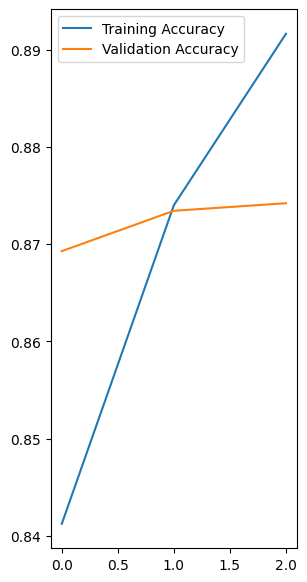

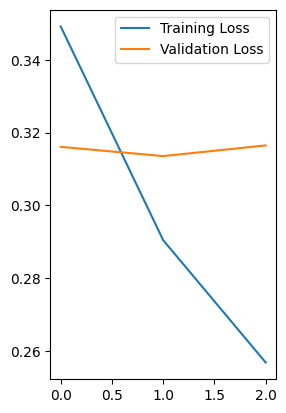

In [9]:
plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

plt.subplot(1,2,2)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()



In [32]:
examples = ["Kilmar Armado Abrego-Garcia “was a convicted MS-13 gang member."]


results = tf.sigmoid(model_2(tf.constant(examples)))
print(results)


tf.Tensor([[0.9890604]], shape=(1, 1), dtype=float32)


In [34]:
predictions = model_2.predict(X_test)

1854/1854 [==============================] - 85s 46ms/step


In [35]:
threshold = 0.5
preds = (predictions>threshold).astype(int)

print(classification_report(preds,y_test, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       0.91      0.88      0.90     37254
        Real       0.81      0.86      0.83     22065

    accuracy                           0.87     59319
   macro avg       0.86      0.87      0.87     59319
weighted avg       0.88      0.87      0.87     59319



## FINE-TUNING GPT2 ##

The following code fine tunes GPT2. It uses the TFGPT2Model from hugging face. This, in contrast with TFGPT2LMHeadModel, does not include the final linear-plus-softmax layer and so it only outputs the hidden states and can be used for any downstream task (like, for example, classification). More specifically, in my case I am going to use the last token (since it is a substitute for lets say the CLS token in BERT although not the same) with the logic that by then the model has seen all the sentence and I am going to use this into a classification layer.

In [5]:
BATCH_SIZE = 16
SEED = 42
# Training data
X_train = data_train['clean_title'].values
y_train = data_train['2_way_label'].values

X_val = data_validate['clean_title'].values
y_val = data_validate['2_way_label'].values


In [6]:
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
gpt2 = TFGPT2Model.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.eos_token
gpt2.config.pad_token_id = tokenizer.eos_token_id
gpt2.config.use_cache = False  

c:\Users\makri\.conda\envs\tf\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [7]:
train_encodings = tokenizer(list(X_train), truncation=True, padding='max_length', max_length=30, return_tensors="tf")

val_encodings = tokenizer(
    list(X_val),
    truncation=True,
    padding='max_length',
    max_length=30,
    return_tensors="tf"
)


In [6]:
# Prepare dataset
inputs = {
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask']
}
labels = tf.cast(y_train, tf.float32)


val_inputs = {
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask']
}
val_labels = tf.cast(y_val, tf.float32)

# Now build dataset properly
train_ds = tf.data.Dataset.from_tensor_slices((inputs,  labels)).shuffle(buffer_size=len(X_train),seed=SEED, reshuffle_each_iteration=False).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_inputs, val_labels))\
         .batch(BATCH_SIZE)\
         .prefetch(tf.data.AUTOTUNE)

In [ ]:
# Build Model
mixed_precision.set_global_policy('mixed_float16')

# Input layers
input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="attention_mask")

# Extract last hidden state 
gpt2_outputs = gpt2({'input_ids': input_ids, 'attention_mask': attention_mask})
last_hidden = gpt2_outputs.last_hidden_state # Dim : [batch_size,seq_lenth,hidden_size]

# Extracat last token last_hidden_state ("cls" token)
cls_token = last_hidden[:, -1, :]


# Mean pooling
mask = tf.cast(tf.expand_dims(attention_mask, axis=-1), dtype=tf.float32) # Dim : [batch_size,seq_lenth,1]
masked_hidden = last_hidden * mask # Dim : [batch_size,seq_lenth,hidden_size]
sum_hidden = tf.reduce_sum(masked_hidden, axis=1) # Sum of non-masked embeddings
token_counts = tf.reduce_sum(mask, axis=1) #Sum of non-padded tokens
mean_hidden = sum_hidden / tf.maximum(token_counts, 1e-9)

# Combine both
combined = tf.concat([cls_token, mean_hidden], axis=1)  # shape: (batch, hidden_size * 2)

# Classification layer
preds = tf.keras.layers.Dense(1, activation="sigmoid", dtype="float32")(combined)

# Final Model
model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=preds)

model.summary()



INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4050 Laptop GPU, compute capability 8.9
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, None, 1)      0           ['attention_mask[0][0]']         
                                        

In [8]:
tf.keras.backend.clear_session(
)


In [9]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(5e-5), metrics = ['accuracy'])

In [10]:
history = model.fit(train_ds, validation_data=val_ds, epochs=3)


Epoch 1/3
35250/35250 [==============================] - 4283s 121ms/step - loss: 0.3309 - accuracy: 0.8579 - val_loss: 0.3065 - val_accuracy: 0.8714
Epoch 2/3
35250/35250 [==============================] - 4270s 121ms/step - loss: 0.2630 - accuracy: 0.8920 - val_loss: 0.3041 - val_accuracy: 0.8786
Epoch 3/3
35250/35250 [==============================] - 4254s 121ms/step - loss: 0.2146 - accuracy: 0.9142 - val_loss: 0.3310 - val_accuracy: 0.8753


In [11]:

X_test = data_test['clean_title'].values
y_test = data_test['2_way_label'].values



test_encodings = tokenizer(list(X_test), truncation=True, padding='max_length', max_length=30, return_tensors="tf")

predictions = model.predict(dict(test_encodings))

threshold = 0.5
preds = (predictions>threshold).astype(int)

print(classification_report(preds,y_test, target_names = ['Fake','Real']))

1854/1854 [==============================] - 72s 38ms/step
              precision    recall  f1-score   support

        Fake       0.89      0.90      0.90     35408
        Real       0.85      0.84      0.85     23911

    accuracy                           0.88     59319
   macro avg       0.87      0.87      0.87     59319
weighted avg       0.88      0.88      0.88     59319



In [12]:
model.save('./my_model_gpt2')

INFO:tensorflow:Assets written to: ./my_model_gpt2\assets


INFO:tensorflow:Assets written to: ./my_model_gpt2\assets
